In [3]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from scipy.signal import butter, filtfilt
from sklearn.metrics import roc_curve
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams

import h5py, numpy as np
import os

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [4]:
fig_dir = "./figures"
results_dir = "./results"

### Loading saved scores

In [13]:
learning_rate = 2e-7

Score_BG_total = os.path.join(results_dir, f"{learning_rate}/LHC_L1T_Score_BG_test_lr_{learning_rate}.npy")
Score_LQ = os.path.join(results_dir, f"{learning_rate}/LHC_L1T_Score_LQ_lr_{learning_rate}.npy")
Score_A = os.path.join(results_dir, f"{learning_rate}/LHC_L1T_Score_A_lr_{learning_rate}.npy")
Score_h0 = os.path.join(results_dir, f"{learning_rate}/LHC_L1T_Score_h0_lr_{learning_rate}.npy")
Score_hpn = os.path.join(results_dir, f"{learning_rate}/LHC_L1T_Score_hpn_lr_{learning_rate}.npy")

conc_scores_bg_LQ = np.concatenate([np.load(Score_BG_total), np.load(Score_LQ)])
conc_scores_bg_A = np.concatenate([np.load(Score_BG_total), np.load(Score_A)])
conc_scores_bg_h0 = np.concatenate([np.load(Score_BG_total), np.load(Score_h0)])
conc_scores_bg_hpn = np.concatenate([np.load(Score_BG_total), np.load(Score_hpn)])

labels_bg_LQ = np.concatenate([np.zeros(len(np.load(Score_BG_total))), np.ones(len(np.load(Score_LQ)))])
labels_bg_A = np.concatenate([np.zeros(len(np.load(Score_BG_total))), np.ones(len(np.load(Score_A)))])
labels_bg_h0 = np.concatenate([np.zeros(len(np.load(Score_BG_total))), np.ones(len(np.load(Score_h0)))])
labels_bg_hpn = np.concatenate([np.zeros(len(np.load(Score_BG_total))), np.ones(len(np.load(Score_hpn)))])

### ROC calculations

In [14]:
fpr_1, tpr_1, thresholds_1 = roc_curve(labels_bg_LQ, conc_scores_bg_LQ)
fpr_2, tpr_2, thresholds_2 = roc_curve(labels_bg_A, conc_scores_bg_A)
fpr_3, tpr_3, thresholds_3 = roc_curve(labels_bg_h0, conc_scores_bg_h0)
fpr_4, tpr_4, thresholds_4 = roc_curve(labels_bg_hpn, conc_scores_bg_hpn)
# AUC
AUC1 = roc_auc_score(labels_bg_LQ, conc_scores_bg_LQ)
AUC2 = roc_auc_score(labels_bg_A, conc_scores_bg_A)
AUC3 = roc_auc_score(labels_bg_h0, conc_scores_bg_h0)
AUC4 = roc_auc_score(labels_bg_hpn, conc_scores_bg_hpn)

# Producing figures

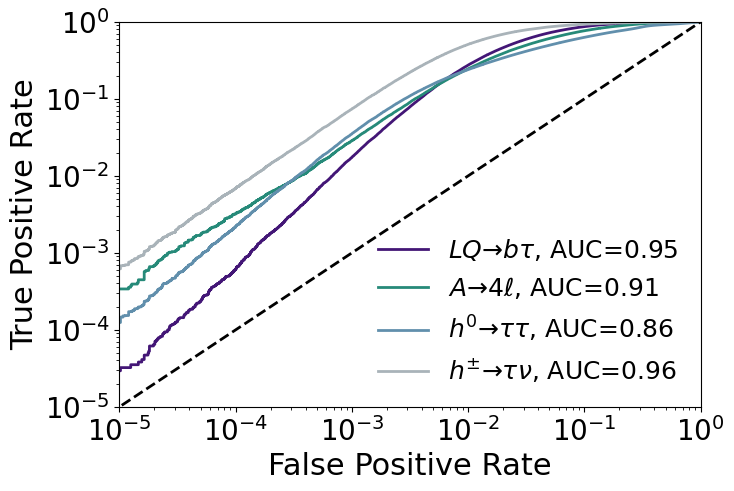

In [19]:
# -------- SETTINGS --------
# Custom color palette (tweak these HEX values to tune colors)
palette = [
    "#431676",  # blue
    "#268a79",  # orange
    "#618fac",  # red
    "#a9b3b9"  # green
]
# make legend markers larger
plt.rcParams['legend.markerscale'] = 2

# Font settings (Times New Roman or similar serif)
rcParams['font.family'] = ['sans-serif']
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['legend.fontsize'] = 18
rcParams['lines.linewidth'] = 2
rcParams['legend.frameon'] = False

# figure for all signals
fig, ax = plt.subplots(figsize=(7.5, 5))
plt.plot(fpr_1, tpr_1, label=f'${{LQ → bτ}}$, AUC={AUC1:.2f}', color=palette[0])
plt.plot(fpr_2, tpr_2, label=f'$A → 4\ell$, AUC={AUC2:.2f}', color=palette[1])
plt.plot(fpr_3, tpr_3, label=f'${{h^0}} → ττ$, AUC={AUC3:.2f}', color=palette[2])
plt.plot(fpr_4, tpr_4, label=f'${{h^±}} → τν$, AUC={AUC4:.2f}', color=palette[3])
min_fpr = min([fpr_1[fpr_1 > 0].min(), fpr_2[fpr_2 > 0].min(), fpr_3[fpr_3 > 0].min(), fpr_4[fpr_4 > 0].min()])   # smallest non-zero FPR
plt.loglog([min_fpr, 1], [min_fpr, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.grid(True, which="both")
plt.legend()
xlimit = (1e-5, 1.0)
plt.xlim(xlimit)
plt.ylim((1e-5, 1.0))
plt.xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0])
plt.savefig(os.path.join(fig_dir,f'TPR_FPR_LHC_lr_{learning_rate}.pdf'), dpi=1200, bbox_inches='tight')
plt.show()